In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
symbols = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

img_width = 140
img_height = 80
n_class = len(symbols) # len(symbols) == 36
num_char = 4

# Data generator

In [15]:
from captcha.image import ImageCaptcha
import random

def gen(batch_size=64, save_img = False, save_dir = ''):
    X = np.empty((batch_size, img_height, img_width, 3), dtype=np.uint8)
    Y = [np.empty((batch_size, n_class), dtype=np.uint8) for i in range(num_char)]
    generator = ImageCaptcha(width=img_width, height=img_height)
    while True:
        for i in range(batch_size):
            random_str = ''.join(random.sample(symbols, num_char))
            img = generator.generate_image(random_str)
            if save_img == True:
                plt.imsave(save_dir+random_str+".jpg",np.array(img))
            X[i] = img
            for digit, ch in enumerate(random_str):
                Y[digit][i, :] = 0
                Y[digit][i, symbols.find(ch)] = 1
        yield X, Y
        
# Decoder
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([symbols[c] for c in y])

# Test

(-0.5, 139.5, 79.5, -0.5)

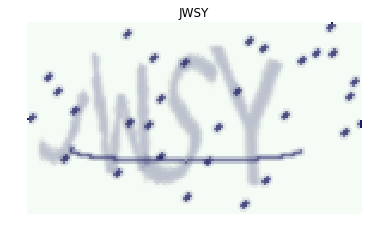

In [16]:
(X, y) = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))
plt.axis('off')

# CNN

In [5]:
from keras.models import *
from keras.layers import *

input_layer = Input(shape = (img_height, img_width, 3))
layers = Conv2D(32, (3, 3), activation='relu')(input_layer)
layers = Conv2D(32, (3, 3), activation='relu')(layers)
layers = MaxPooling2D((2, 2))(layers)

layers = Conv2D(64, (3, 3), activation='relu')(layers)
layers = Conv2D(64, (3, 3), activation='relu')(layers)
layers = MaxPooling2D((2, 2))(layers)

layers = Conv2D(128, (3, 3), activation='relu')(layers)
layers = Conv2D(128, (3, 3), activation='relu')(layers)
layers = MaxPooling2D((2, 2))(layers)

layers = Conv2D(256, (3, 3), activation='relu')(layers)
layers = Conv2D(256, (3, 3), activation='relu')(layers)
layers = MaxPooling2D((2, 2))(layers)

layers = Flatten()(layers)
layers = Dropout(0.2)(layers)
layers = [Dense(n_class, activation='softmax',  name='digit_%d'%i)(layers) for i in range(4)]

model = Model(inputs = input_layer, outputs = layers)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

c:\users\zhongzhu\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Training

In [7]:
batch_size = 256
samples =64000
val_samples = 1024
h = model.fit_generator(gen(batch_size = batch_size), steps_per_epoch = samples/batch_size, epochs=15,
                        validation_data=gen(batch_size = batch_size), validation_steps = val_samples/batch_size, 
                        verbose = 0)

In [8]:
h.history

{'digit_0_acc': [0.026953125,
  0.09371875,
  0.707578125,
  0.924046875,
  0.957984375,
  0.971484375,
  0.976765625,
  0.98084375,
  0.98378125,
  0.985390625,
  0.9863125,
  0.987609375,
  0.989359375,
  0.990953125,
  0.990546875],
 'digit_0_loss': [3.586136291503906,
  3.3478542776107787,
  0.9154006935358048,
  0.23222777158021926,
  0.12433241388201713,
  0.0843389997035265,
  0.06958779537677764,
  0.05838069211691618,
  0.05279234378039837,
  0.04573429611325264,
  0.05296040728315711,
  0.037982806196436285,
  0.03399750027433038,
  0.03271822387166321,
  0.029677180115133525],
 'digit_1_acc': [0.02790625,
  0.22925,
  0.832046875,
  0.941203125,
  0.95703125,
  0.96375,
  0.9663125,
  0.969703125,
  0.97178125,
  0.97425,
  0.975921875,
  0.976859375,
  0.977796875,
  0.978625,
  0.97853125],
 'digit_1_loss': [3.583859649658203,
  2.732372127532959,
  0.6120246464014053,
  0.2926597466468811,
  0.24302636405825614,
  0.22969382826983928,
  0.22634259118139743,
  0.2094278736

Populating the interactive namespace from numpy and matplotlib


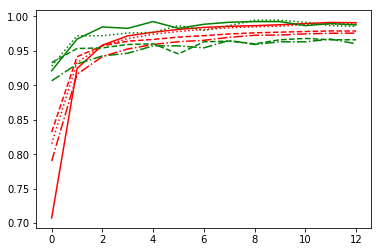

In [12]:
%pylab inline
pt0 = h.history['digit_0_acc']
pt1 = h.history['digit_1_acc']
pt2 = h.history['digit_2_acc']
pt3 = h.history['digit_3_acc']
pv0 = h.history['val_digit_0_acc']
pv1 = h.history['val_digit_1_acc']
pv2 = h.history['val_digit_2_acc']
pv3 = h.history['val_digit_3_acc']
plot(pt0[2:], 'r-')
plot(pt1[2:], 'r--')
plot(pt2[2:], 'r-.')
plot(pt3[2:], 'r:')
plot(pv0[2:], 'g-')
plot(pv1[2:], 'g--')
plot(pv2[2:], 'g-.')
plot(pv3[2:], 'g:')
#print(np.max(pt), np.max(pv), np.argmax(pv)) 

# Testing accuracy of trained model

In [17]:
def evaluate(model, test_num=1000):
    correct = 0
    generator = gen(1,save_img = True, save_dir = 'test_img/')
    for i in range(test_num):
        X, y = next(generator)
        y_pred = model.predict(X)
        y = decode(y)
        y_pred = decode(y_pred)
        #print(y, y_pred)
        if y == y_pred:
            correct += 1
        else:
            print(y, y_pred) #print wrong prediction
    return correct / test_num

test_acc = evaluate(model)
print(test_acc)

0NWF ONWF
IMB0 IMBO
RDOW RD0W
DRY0 DRYO
83ON 830N
VO3D V03D
0Z1Y OZ1Y
0JXS OJXS
0ICO 0IC0
WN80 WN8O
3K0E 3KHR
3O2R 302R
LOM9 L0M9
NP0J NPOJ
3Z0K 3ZOK
S40E S4OE
LN80 LN8O
60UI 6OUI
QR08 QRO8
HJLU HJUU
HWG0 HWGO
V40B V4OB
1SW0 1SWO
0LTQ OLTQ
0QXB OQXB
0C1R OC1R
JKO5 JK05
BDA0 BDAO
ZCSJ LCSD
J20A J2OA
0RFL ORFL
5HDP SHDP
EOVU E0VU
A0MX AOMX
0PLK OPLK
0UHC OUHC
LTF0 LTFO
0.963


# Test Sample

(-0.5, 139.5, 79.5, -0.5)

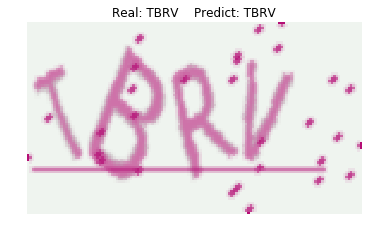

In [18]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('Real: %s    Predict: %s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# Save/Load model

In [19]:
model.save('CAPTCHA_Cracker_3.h5')

In [6]:
from keras.models import load_model
model = load_model('trained_cnn.h5')